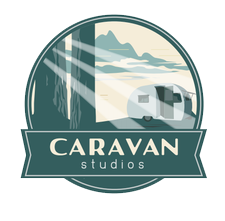

##### Hadrien N Picq
###### Citizen Science Research Intern

## Due: February ~~8th~~ 11th, 2018 @ ~~11 am~~ 8am
*rescheduled meeting*

## Asks:

### I. Chart a trendline of Luftdaten's Air Quality data over an unspecified period of time (TBD on data availability);

### II. Map Luftdaten's sensors. Select an area within the EU with a high density of sensor measurements;

### III. Overlay sampling stations with data points of *public libraries*, and assess proximity between data points;

### <span style="color:green">*IV. Overlay relevant socio-economic demographic data over the area of interest, and explore potential corrolary relationships with air quality.*<span/>

### <span style="color:green">*V. Research which groups/programs/apps make use of Luftdaten's data, i.e. research prior case studies;*<span/>

### <span style="color:green">*VI. Note any pertinent thoughts to Environmental Impact Assessment.*<span/>

---

## Challenges

* Working with such a large datafile a first experience;
* Doing data analysis on a large dataset despite hardware limitations;
* Properly configuring my computer's OS to smoothly run python packages and specialized software;
* Parsing through a foreign language data-source without thorough metadata documentation;
* Assessing the usability of available APIs for Luftdaten;
* Searching for geospatial data: Germany's public libraries;
* Properly interpreting the current data output.

## Positives

* Success manipulating a large dataset by exporting it into a relational database (SQL);
* Successful debugging of faulty python environment set-up, software compatibility issues;
* Produced various visual data output which can be further expanded on;
* Gained insights into Luftdaten's data collection and cataloging;
* Gained an understanding of the spatial layout (globally) of Luftdaten's active sensors;
* Despite not meeting all the asks within the first week, progress has been exponientially achieved.

---

## Background on Data Retrievability

* The API provided does not seem to be configured to query temporal ranges: https://github.com/opendata-stuttgart/meta/wiki/APIs

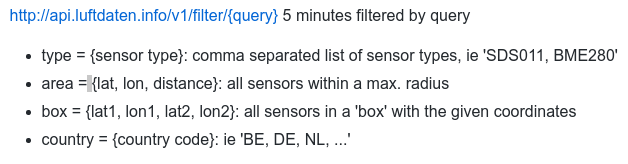

My guess is due to the very large volume of data collected (every minutes), the call requests limit would need to be either quite steep or the data would have to be preconfigured (i.e. averaged by hours or days) to be "digestible". To be fair to Luftdaten, API queries can be made to collect data collected within the last 5 minutes, and their archive of data does aggregate measurement by the days or the months. But I don't believe it's retrievable via APIs. 
 
* The API Client isn't yet configured to be quite user-friendly: https://github.com/opendata-stuttgart/feinstaub-api/issues/12


* Data can be retrieved via the archive directory as csv files, aggregated either by days or months since October 2015: http://archive.luftdaten.info/


* Furthermore, the data is categorized by sensor's type (see screenshot below). While Luftdaten has a wiki published on Github, its sections about sensor specifications is incomplete (https://github.com/opendata-stuttgart/meta/wiki/Datenbl%C3%A4tter-Spezifikationen). Sadly it does not concisely lists its metadata onto a page nor--preferrably--on a pdf document within the archive directory. Thus I had to research the various sensors to identify the parameters I am seeking to analyze.

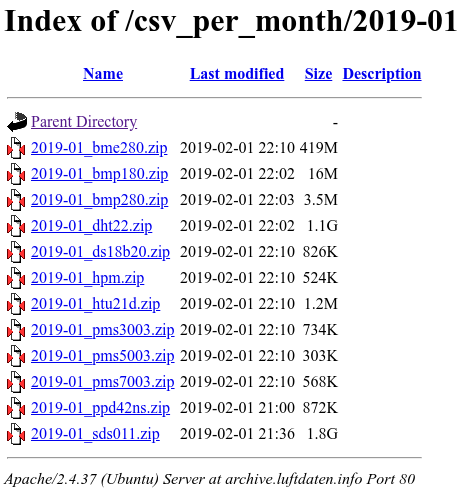

These are the 3 sensors which are active in the greatest numbers, per Luftdaten's active sensors chart which can be accessed at https://api.luftdaten.info/static/v1/stats_active_sensors.svg


> 1. [sds011](https://github.com/opendata-stuttgart/meta/blob/master/files/SDS011-V1.3.pdf): LASER PM2.5 SENSOR, 
measures PM2.5 & PM10
> 2. [dht22](https://github.com/opendata-stuttgart/meta/blob/master/files/DHT22.pdf): DIGITAL-OUTPUT RELATIVE HUMIDITY & TEMPERATURE SENSOR/MODULE, measures temperature and humidity
> 3. [bme280](https://www.bosch-sensortec.com/bst/products/all_products/bme280): INTEGRATED ENVIRONMENTAL UNITS, also measures temperature and humidity, although it can be worn as a wristband, so its location may not be as static as the dht22

While there seems to be many other sensors measuring particulate matters, for the scope of my analysis I will limit myself to the data provided by the sds011 sensor.


*As a footnote, [openSenseMap](https://opensensemap.org/) hosts a large number of open sensor data, including Luftdaten's, and provides a manual user interface to download data by map area (which can only be defined via zooming). However I found the interface to be lacking, and the sensor data I downloaded for a month's worth of measurement was so great that I could not effectively edit it in QGIS (partly because of the lack of granulirity in selecting an area to bound the volume of data).*

---

In [2]:
# Import all relevant packages here

import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import dask.dataframe as dd 
#     # Experimentation: can be used to read large csvs into panda, otherwise not useful

import os
from tqdm import tqdm #https://pypi.org/project/tqdm/#latest-pypi-stable-release

from sqlalchemy import create_engine, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import sqlite3

import plotly.plotly as py
import plotly.graph_objs as go

 ---

### I. Charting Temporal trends

In [3]:
%%time

# Reference: https://pythondata.com/working-large-csv-files-python/

    
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! # ONE TIME process only! # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #
                # Export CSV to a SQLITE DB, so that queries are manageable in-memory.
    
datatypes = {'sensor_id': 'int32',
              'lat': 'float32', 
              'lon': 'float32',
              'timestamp': 'str',
              'P1': 'float32',
              'P2': 'float32'} # Convert the datat types into "smaller" format, to compress on memory

cols = list(datatypes.keys())

chunksize = 10 ** 6 # Chuncking the csv by 1 million rows per iterations (for a csv doc with 99M rows!)

file = 'raw/luftdaten_sds011_Jan2019.csv'

csv_database = create_engine('sqlite:///csv_database.db') # Generated a 8.5GB file! (why?)

i = 0
j = 1
for df in tqdm(pd.read_csv(file, sep=';', usecols=cols, dtype=datatypes, chunksize=chunksize, iterator=True)):
      df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
      df.index += j
      i+=1
      df.to_sql('table', csv_database, if_exists='append')
      j = df.index[-1] + 1

100it [17:46,  8.09s/it]

CPU times: user 16min 14s, sys: 41.2 s, total: 16min 55s
Wall time: 17min 46s


In [7]:
        # !!!!!!!!!!!!!!!! READ SQLITE Database HERE for all future manipulation !!!!!!!!!!!!!!!! #

csv_database = create_engine('sqlite:///csv_database.db')
inspector = inspect(csv_database)
print(inspector.get_table_names())

columns = inspector.get_columns('table')
for column in columns:
    print(column["name"], column["type"])

['table']
index BIGINT
sensor_id INTEGER
lat FLOAT
lon FLOAT
timestamp TEXT
P1 FLOAT
P2 FLOAT


In [9]:
%%time

# Select relevant attributes from SQLITE table to chart time serie

conn = sqlite3.connect("csv_database.db")
timeS_df = pd.read_sql_query("select timestamp, AVG(P1), AVG(P2) from 'table' group by timestamp", conn)
hist_df = pd.read_sql_query("select sensor_id, AVG(P1), AVG(P2) from 'table' group by sensor_id", conn)
map_df = pd.read_sql_query("select sensor_id, lat, lon from 'table' group by sensor_id", conn)

CPU times: user 607 µs, sys: 269 µs, total: 876 µs
Wall time: 533 µs


In [39]:
# Convert timestamp into datatime, splice the days
timeS_df['timestamp'] = pd.to_datetime(timeS_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
timeS_df['day'] = timeS_df['timestamp'].dt.day
print(timeS_df.dtypes)
print('-----------------------------------------------')
dayTimeSpm25 = timeS_df.groupby('day')['AVG(P1)'].mean() #PM2.5
dayTimeSpm25 = pd.DataFrame(data=dayTimeSpm25)

dayTimeSpm10 = timeS_df.groupby('day')['AVG(P2)'].mean() #PM10
dayTimeSpm10 = pd.DataFrame(data=dayTimeSpm10)

dayTimeS = dayTimeSpm25.join(dayTimeSpm10, lsuffix='_pm2.5', rsuffix='_pm10').reset_index()
dayTimeS.head() # Joined dataframe with the measurement data averaged for each day

timestamp    datetime64[ns]
AVG(P1)             float64
AVG(P2)             float64
day                   int64
dtype: object
-----------------------------------------------


,day,AVG(P1),AVG(P2)
0,1,39.782160,21.356699
1,2,21.016411,8.946090
2,3,19.307217,9.869189
3,4,29.736251,16.414329
4,5,24.153731,12.933851


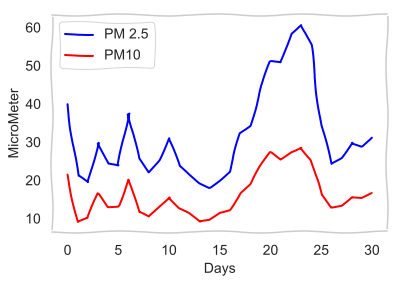

<Figure size 432x288 with 0 Axes>

In [48]:
# https://plot.ly/pandas/line-charts/

#################### Using plotly
import plotly.plotly as py
import plotly.graph_objs as go

x = dayTimeS['day']
y = dayTimeS['AVG(P1)']
df = pd.DataFrame({'x': x, 'y': y})
df.head()

x2 = dayTimeS['day']
y2 = dayTimeS['AVG(P2)']
df2 = pd.DataFrame({'x': x2, 'y': y2})
df2.head()

data = [
    go.Scatter(
        x=df['x'],
        y=df['y'],
        name='PM2.5'
    ),
    go.Scatter(
        x=df2['x'],
        y=df2['y'],
        name='PM10'
    )
]

url = plotly.offline.plot(data, filename='trendlines_Jan2019.html')


#################### Using seaborn
with plt.xkcd():

    sns.set_style("whitegrid")
    plt.plot(dayTimeS['AVG(P1)'],color='blue',label="PM 2.5")
    plt.plot(dayTimeS['AVG(P2)'],color='red',label="PM10")
    plt.title('')
    plt.xlabel('Days')
    plt.ylabel('MicroMeter')
    plt.legend(loc=2, ncol=1)

    plt.show()

    plt.savefig('outputs/timeSeries_Luftdaten.png')

Plotly's charts are interactive, although I could only save an html file (which is easily embeddable):
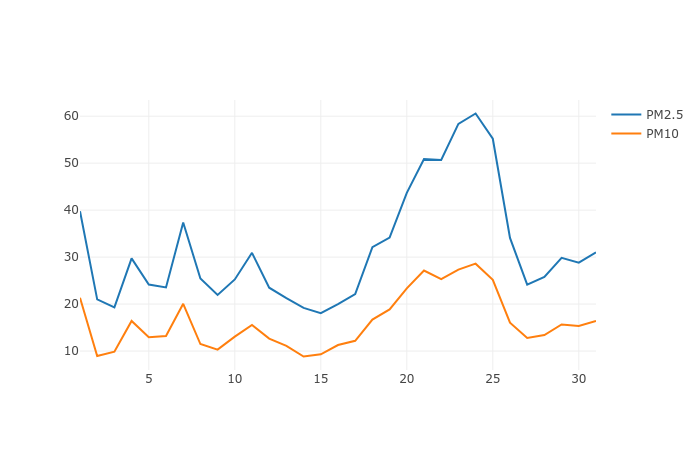

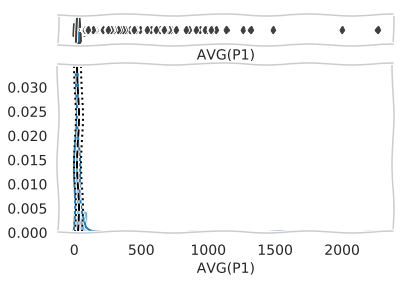

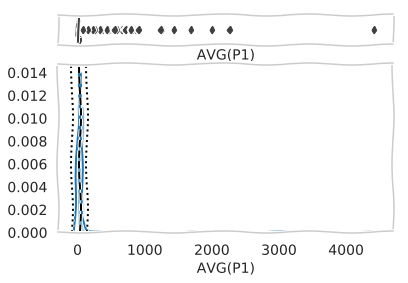

In [10]:
# Histograms & Boxplots

############################ Data distribution at every second measured (averaged)
timeS_df # 2,672,600 (avg by timestamp, i.e. by each seconds)

timeS_mean = timeS_df['AVG(P1)'].mean()
timeS_std1 = timeS_mean + timeS_df['AVG(P1)'].std()
timeS_std2 = timeS_mean - timeS_df['AVG(P1)'].std()
with plt.xkcd():
    sns.set_style("whitegrid")

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    ax_box.set(xlabel='Histograms of Measurements, Jan. 2019')
    
    sns.boxplot(timeS_df['AVG(P1)'], ax=ax_box)
    sns.distplot(timeS_df['AVG(P1)'], ax=ax_hist)
    plt.axvline(timeS_mean, linestyle="dashed",color='black')
    # Adding the standard deviation lines
    plt.axvline(timeS_std1, linestyle="dotted",color='black')
    plt.axvline(timeS_std2, linestyle="dotted",color='black')
    
    plt.savefig('outputs/hist_timeS_Lufdaten.png')
    
############################ Data distribution at every sensor station (averaged)
hist_df # 7335 rows (avg by stations)

hist_mean = hist_df['AVG(P1)'].mean()
hist_std1 = hist_mean + hist_df['AVG(P1)'].std()
hist_std2 = hist_mean - hist_df['AVG(P1)'].std()
with plt.xkcd():
    sns.set_style("whitegrid")

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    ax_box.set(xlabel='Histograms of Measurements, Jan. 2019')
    
    sns.boxplot(hist_df['AVG(P1)'], ax=ax_box)
    sns.distplot(hist_df['AVG(P1)'], ax=ax_hist)
    plt.axvline(hist_mean, linestyle="dashed",color='black')
    # Adding the standard deviation lines
    plt.axvline(hist_std1, linestyle="dotted",color='black')
    plt.axvline(hist_std2, linestyle="dotted",color='black')
    
    plt.savefig('outputs/hist_stations_Lufdaten.png')

What the histograms are telling us here is that we've plenty of data points which are outlier values, and may skew our analysis. Marnie mentioned the effect of having many sensors to mitigate for uncalibrated meters or errors, and observing the data's distribution enables us to make determination about the validity of the data and/or particular data points.

The first histogram shows distribution of data averaged at every second of measurement. Thus, even if a single sensor is uncalibrated and exaggerates its measurements, we may have plenty of outlier values that need to be removed. However, and this is *important*, we are taking data with no defined geographic boundaries. Thus that single sensor with "outrageous" value might be accurate, but may also be the sole representative of its location.

Thus, we need to make sure the data is properly distributed and is *representative* of its location. Which is what we can try to deduce from the second histogram, which averages PM2.5 readings per sensor.

---

### II. Mapping the Sensors' Location

In [47]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = go.Figure(
    data=[
        go.Scattergeo(
            lat=map_df.lat,
            lon=map_df.lon,
            marker={
                "color": 'blue',
                "line": {
                    "width": 1
                },
                "size": 5
            },
            mode="markers+text",
            name="",
            textposition=["top center"]
        )
    ],
    layout={
        "title": "Sensors",
        "geo": {
            "lataxis": {
                "range": [-90, 90]
            },
            "lonaxis": {
                "range": [-180, -180]
            },
            "scope": "world"
        }
    }
)



url = plotly.offline.plot(fig, filename='sensorMapping_Jan2019.html')

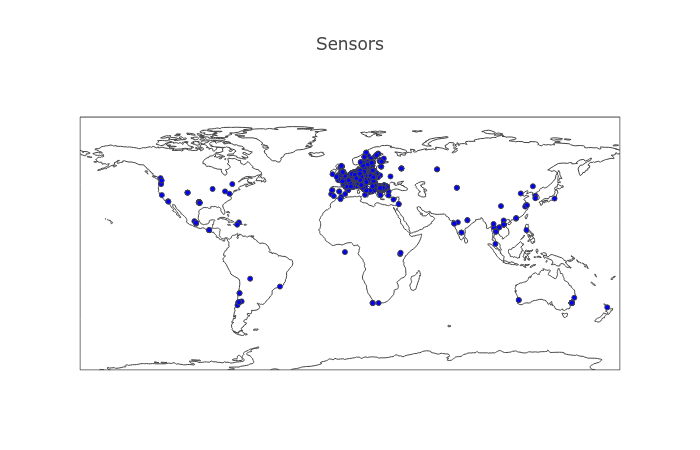

---

### III. Proximity to Public Libraries

In order to analyze proximity between libraries and sensors, a geographic scope needs to be defined. I have made a determination to confine my analysis to the <span style="color:red">~~lander of Baden-Württemberg~~ city of Stuttgart</span> because 1) it has a high density of sensors, and 2) is more accessible when looking for feature data like public library locations and socio-economic data <span style="color:red">, and 3) due to difficulty acquiring a thorough set of geocentric data of public libraries for the whole region of Baden-Württemberg, I will further limit the geographic scope to a city, albeit a major urban area with plenty of high-density active sensors mapped.</span>

In [10]:
sds_df = pd.read_sql_query("select sensor_id, AVG(P1), lat, lon from 'table' group by sensor_id", conn)

In [61]:
sds_df.to_csv("outputs/sensorCoords.csv")

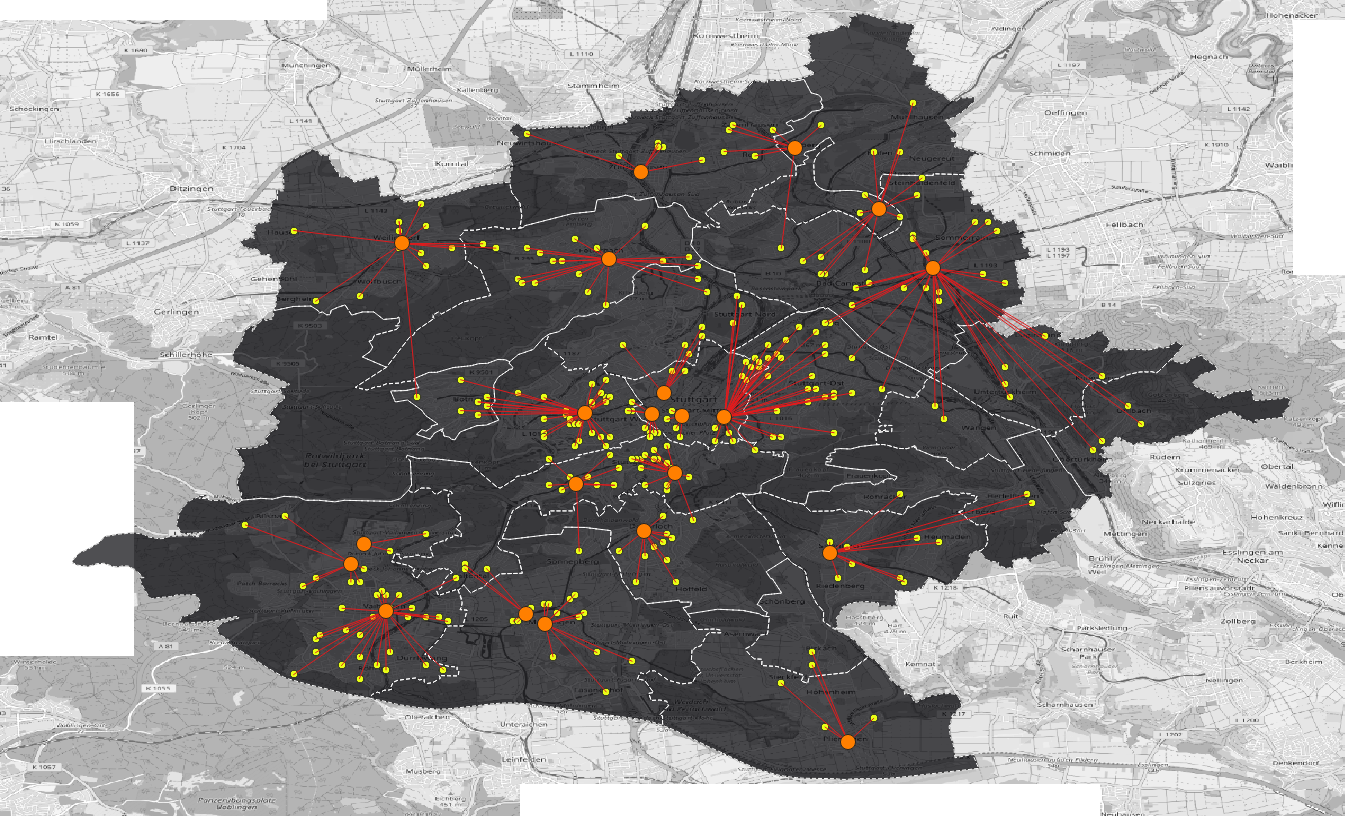
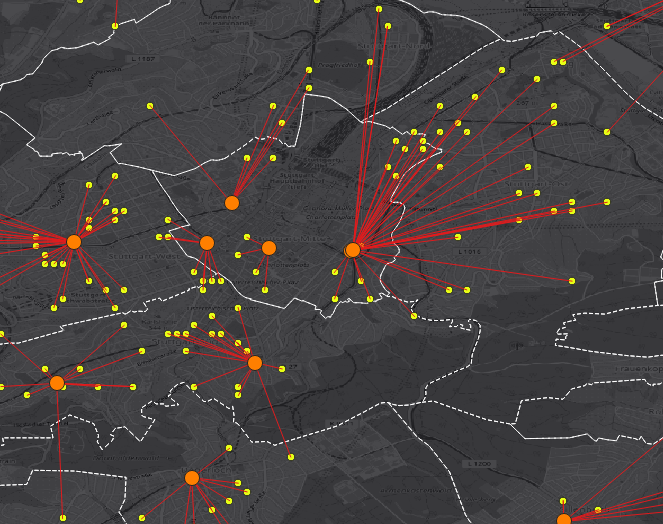

In [ ]:
# https://mapcruzin.com/free-germany-arcgis-maps-shapefiles.htm
    # Point and geom data of places of interests in Germany

---

## Objectives Re-Assessment

* The 3 remaining asks can be realistically be completed by the end of Week 2; 
* I will record how much time is spent on each objective more accurately: using Wakatime for programmatic tasks;
* Will develop a presentation format better suited to summarize progress;
* Will push to GitHub on a daily basis of the code used for the objectives, as a means of safekeeping and so that my work can be accessed at all time;
* I can also publish a copy or formatted version of the Jupyter Notebook file to Caravan Intern's G-Drive or Sharepoint;
* The scope of the analysis between air quality and attributes pertaining to socio-economic data will have to be better defined;
* The scope of the spatial analysis between libraries and sensors will have to be better defined;
* Themes pertaining to EIA will be actively re-incorporated into my assessment of the data.